## This notebook is for testing the SDK before using any scripts for data retrieval / live feed
- Make sure you have the .env file with the corrent variable names listed below before running the code

In [1]:
# Authentication for streaming data
from neurosity import NeurositySDK
from dotenv import load_dotenv
import os

load_dotenv()

neurosity = NeurositySDK({
    "device_id": os.getenv("NEUROSITY_DEVICE_ID")
})

neurosity.login({
    "email": os.getenv("NEUROSITY_EMAIL"),
    "password": os.getenv("NEUROSITY_PASSWORD")
})

In [2]:
# checking the info from the SDK
info = neurosity.get_info()
print(info)

OrderedDict({'channelNames': ['CP6', 'F6', 'C4', 'CP4', 'CP3', 'F5', 'C3', 'CP5'], 'channels': 8, 'deviceId': 'e425ea92bcd7bdae65a5c2b07322433d', 'deviceNickname': 'Emulator-E42', 'emulator': True, 'manufacturer': 'Neurosity, Inc', 'model': 'Emulator 2', 'modelName': 'Emulator', 'modelVersion': '2', 'osVersion': '14.5.0', 'samplingRate': 250})


# Raw Brainwaves Data

In [3]:
# Retrieving raw brainwaves and storing 1 epoch
import time
sample = 0

def callback(data):
    global sample
    sample = data
    
unsubscribe = neurosity.brainwaves_raw(callback) # the function returned from calling the api is used to stop the data feed

time.sleep(1)

unsubscribe()

In [4]:
import matplotlib.pyplot as plt
import numpy as np
# What one epoch looks like
# print(sample)

# Storing & Visualizing 
channels = ['CP6', 'F6', 'C4', 'CP4', 'CP3', 'F5', 'C3', 'CP5']
data = np.array(sample['data'])  
print(data)
print(data.shape)
print(sample['info'])

[[-17.63890044  -9.04587738  -4.94170945  -6.45525249 -11.73488819
  -16.82488668 -20.71010266 -22.4065216  -19.11337038 -11.22882535
   -2.27113175   4.48129642   6.43103362   4.27183452   2.27468906
    1.52550678   1.13619436   2.4367767    5.3768357    9.55531529
   14.82016305  17.72661645  14.56156415   6.04389754  -2.93264061]
 [-11.93022604 -13.30648642 -13.05338958  -8.72778926   0.275316
   12.92264074  23.45877511  25.38413034  17.91349053   4.45151298
   -9.47089668 -17.23297327 -15.28851259  -5.24557531   7.51284462
   16.22346844  16.61752032  10.27185567   2.5294204   -2.38348056
   -2.27326624   1.36544187   3.38282888   1.69400998  -2.06742412]
 [  0.97708181   5.79497126   1.72711532  -7.65758441 -16.12263436
  -18.88607826 -14.12329149  -5.28088039   2.99738318   7.9676405
    7.70351016   4.1332372    2.91320472   6.01874299  11.51329813
   16.32220496  15.44378638   7.56564486  -1.26055847  -3.70601927
    2.41230948  11.85852456  15.82417982  10.54049197   1.23760

### Epoch Structure
-  the data is recieved as 8 rows, with each row being a channel, and each column being 1 timestamp with the duration between each other depending on the`samplingRate` attribute. 
    E.g. `samplingRate = 250` means 250 samples per second, each sample being 4 ms, and each epoch being 100 ms
- The values themselves range from -40 to +32 microvolts

In [5]:
# Accumilating 5 seconds worth of epochs
data = np.zeros((8,1))
def callback(new):
    new = np.array(new['data'])
    global data
    data = np.concatenate((data,new), axis=1)
    
unsubscribe = neurosity.brainwaves_raw(callback) # the function returned from calling the api is used to stop the data feed

time.sleep(5)

unsubscribe()
print(data)
print(data.shape)

[[  0.          -0.90488662  -2.89947356 ...   6.6648826   -6.88450672
  -18.47293786]
 [  0.          -1.88401029  -3.63053051 ...  13.70207058   8.32405784
    3.69985169]
 [  0.          -0.64043787  -1.26136069 ...  17.88578455  13.08797199
    2.97370098]
 ...
 [  0.           0.45761918   1.19729553 ...  -1.03467058   6.86168609
   11.73489396]
 [  0.          -2.74285691 -16.81565045 ...  21.74047861  11.20554613
   -0.30921039]
 [  0.          12.57656031   9.5703581  ...   4.75304968   5.59741819
    7.14799481]]
(8, 1101)


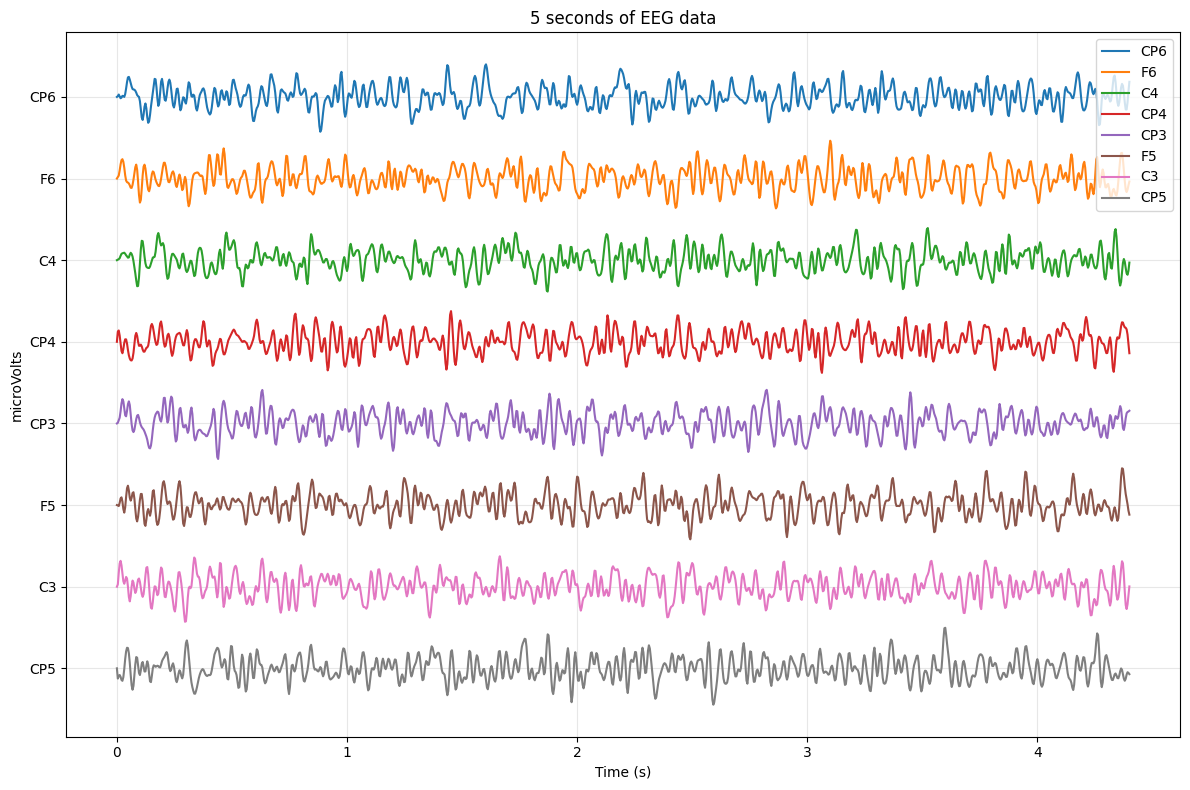

In [6]:
# Visualizing the 5 second window
n_channels, n_samples = data.shape
time = np.arange(n_samples) / 250  # assume 250 Hz sampling rate (adjust!)

plt.figure(figsize=(12, 8))

# Plot each channel with vertical offsets so they don’t overlap
offset = 100  # adjust spacing between signals
for i in range(n_channels):
    plt.plot(time, data[i] + i * offset, label=channels[i])

plt.yticks([i * offset for i in range(n_channels)], channels)
plt.gca().invert_yaxis()

plt.title("5 seconds of EEG data")
plt.xlabel("Time (s)")
plt.ylabel("microVolts")
plt.legend(loc="upper right")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

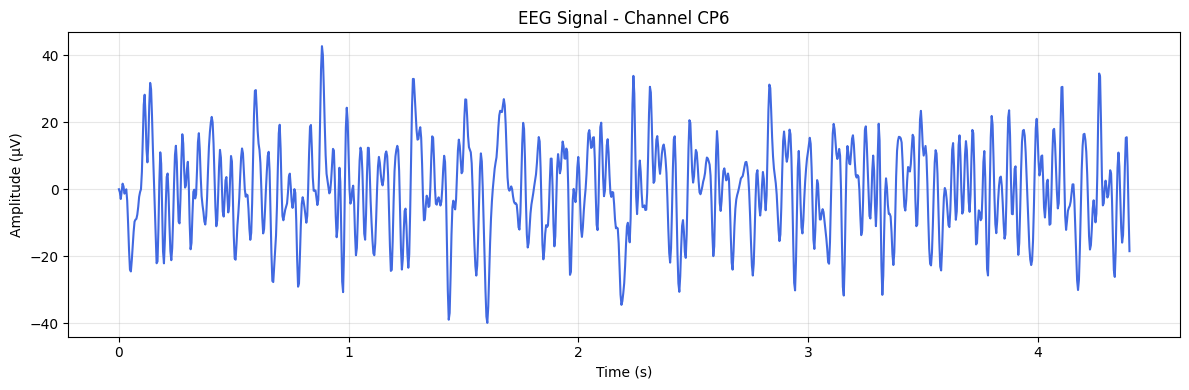

In [7]:
# Visualization for individual channels (e.g. "CP6")
channel_idx = channels.index("CP6")
channel_data = data[channel_idx]

# Sampling rate (adjust to your device)
fs = 250  
time = np.arange(channel_data.shape[0]) / fs

plt.figure(figsize=(12, 4))
plt.plot(time, channel_data, color="royalblue")
plt.title(f"EEG Signal - Channel {channels[channel_idx]}")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (µV)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


# Absolute Power

In [8]:
# Retrieve Absolute Power (AP) brainwaves
import time

ap_sample = None

def ap_callback(data):
    global ap_sample
    ap_sample = data
    print("Absolute Power Update:", data)

# To subscribe to absolute power stream
unsubscribe_ap = neurosity.brainwaves_power_by_band(ap_callback)

# Run for a few seconds
time.sleep(5)

# Stop the subscription
unsubscribe_ap()

print(f"Final Absolute Power Sample: {ap_sample}")

Absolute Power Update: {'data': {'alpha': [1.8852008055922014, 5.941406459976146, 4.549309872376933, 3.5788912287351216, 2.3943923017977777, 2.0405906918427723, 4.563538176664811, 1.9588658943994657], 'beta': [1.5793404541714011, 1.9926011661461969, 1.941923372589687, 2.851239755747952, 2.104894050287716, 2.4894359568165823, 2.7322321996856243, 1.5611768956313719], 'delta': [2.253891063285817, 1.2860488440815736, 1.6460230510132163, 3.581382341879918, 1.5806013401625616, 5.370800800813216, 4.0567239872760075, 4.985602421346955], 'gamma': [0.8450417521336524, 0.4954711672704566, 0.7279375278831762, 0.6897324617346857, 0.6608159357650475, 0.6756528143182265, 0.7814819475668313, 0.7252661459415536], 'theta': [1.5375782936744369, 1.1200560290421278, 1.6856479368329282, 3.9480456057776214, 2.2610909898119784, 5.885187284449618, 5.524864073123608, 5.7186138201770405]}, 'label': 'powerByBand'}
Absolute Power Update: {'data': {'alpha': [2.0954209444498537, 3.088011805752153, 5.15101829265694, 

In [9]:

print(ap_sample['data'])


{'alpha': [3.00306664792345, 1.5732833412366347, 4.48725922215682, 2.4211946078606434, 2.931090952029615, 2.050909026498264, 2.2228852748662047, 2.683382924144327], 'beta': [3.334933859164412, 2.8473954845659346, 2.8805496718056824, 3.447213785324924, 2.5298184316168904, 3.507203920058755, 2.005899374313021, 2.599570221541901], 'delta': [2.060675617495913, 2.662236406679799, 2.9768298409832608, 5.018274233438527, 2.211096931896236, 4.558214106318485, 2.258512105584598, 1.2383943744548682], 'gamma': [0.5938251426204497, 0.5500915565253046, 0.3701840203369511, 0.9869171575362257, 0.9920992461904385, 0.7258069456153114, 0.7324351234822735, 0.7843994639217118], 'theta': [2.916337123898952, 3.058066650170187, 5.2102418070369865, 4.081208941304801, 2.8038869014279317, 3.6951876161127863, 2.7378636528064337, 1.368362192589875]}


# Calm/Focus Data

## Neurosity.calm() quick explanation:

neurosity.calm() streams a probability (0–1) that represents how calm the user is, based on EEG signals.

Difference from raw/absolute power:
Instead of giving you raw brainwave amplitudes (e.g. alpha, beta, gamma), it already applies Neurosity’s built-in model to estimate calmness.

A possible use case that we can use: 
We may define relaxed via low beta & high alpha, for example.

In [14]:
# Retrieve Focus/Calm Probability for 5 seconds
import time

def callback(data):
    print("Probability:", data)

# subscribing to focus and calm streams
focus_unsubscribe = neurosity.focus(callback)
calm_unsubscribe = neurosity.calm(callback)
# Run for a few seconds
time.sleep(5)

# Stop the subscription
focus_unsubscribe()
calm_unsubscribe()
print(f"Final Focus Sample: {sample}")

Probability: {'label': 'focus', 'metric': 'awareness', 'probability': 0.5672621387126188, 'timestamp': 1756198931912}
Probability: {'label': 'calm', 'metric': 'awareness', 'probability': 0.28054661507400436, 'timestamp': 1756198931477}
Probability: {'label': 'calm', 'metric': 'awareness', 'probability': 0.37619317017673437, 'timestamp': 1756198932580}
Probability: {'label': 'focus', 'metric': 'awareness', 'probability': 0.4959203759520175, 'timestamp': 1756198933013}
Probability: {'label': 'calm', 'metric': 'awareness', 'probability': 0.4266703508171421, 'timestamp': 1756198933678}
Probability: {'label': 'focus', 'metric': 'awareness', 'probability': 0.49371831332022315, 'timestamp': 1756198934107}
Probability: {'label': 'calm', 'metric': 'awareness', 'probability': 0.4347906628610263, 'timestamp': 1756198934775}
Probability: {'label': 'focus', 'metric': 'awareness', 'probability': 0.5191385072099869, 'timestamp': 1756198935207}
Probability: {'label': 'calm', 'metric': 'awareness', 'pr